In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np



In [96]:
def try_gpu(i=0):
    """Return MPS device if available, otherwise return CPU."""
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

device = try_gpu()
device

device(type='mps')

In [97]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
z_dim = 256
h_dim=8192
image_channels=3
num_epochs = 400
learning_rate = 3e-4

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to the folder containing Pablo Picasso's images
path = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/GitProjects/_data/art_data/images/images/Pablo_Picasso_only'

# Create a dataset for only the Pablo Picasso folder
dataset = datasets.ImageFolder(path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


## Define Variational Autoencoder

In [98]:
class VAE(nn.Module):
    def __init__(self, image_channels=image_channels, h_dim=h_dim, z_dim=z_dim):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Output of the convolutional layers needs to be flattened
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)
        
        # Decoder network
        self.decoder_fc = nn.Linear(z_dim, h_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output of the encoder
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z).view(-1, 128, 8, 8)  # Reshape for ConvTranspose layers
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Instantiate the model and move it to the device
vae = VAE().to(device)

## Define Loss Function

In [99]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (using MSE or Binary Cross Entropy)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


## Train Variational Autoencoder

In [100]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        
        # Forward pass through the VAE
        recon_batch, mu, logvar = vae(data)
        
        # Compute the loss
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch [1/300], Loss: 3596.7984


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [2/300], Loss: 3161.6175


100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch [3/300], Loss: 2648.9393


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [4/300], Loss: 2292.9838


100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


Epoch [5/300], Loss: 2005.4963


100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch [6/300], Loss: 1812.4740


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [7/300], Loss: 1665.8970


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [8/300], Loss: 1581.3377


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [9/300], Loss: 1513.3437


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [10/300], Loss: 1461.0952


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [11/300], Loss: 1421.1618


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [12/300], Loss: 1388.3963


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [13/300], Loss: 1355.7011


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [14/300], Loss: 1332.5906


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [15/300], Loss: 1305.8203


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [16/300], Loss: 1283.5435


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [17/300], Loss: 1251.8572


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [18/300], Loss: 1236.1841


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch [19/300], Loss: 1218.8978


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [20/300], Loss: 1209.3561


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [21/300], Loss: 1201.3639


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [22/300], Loss: 1194.2263


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [23/300], Loss: 1168.5409


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [24/300], Loss: 1164.2912


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [25/300], Loss: 1158.6493


100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch [26/300], Loss: 1132.2819


100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Epoch [27/300], Loss: 1117.3046


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [28/300], Loss: 1107.6001


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [29/300], Loss: 1095.1086


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [30/300], Loss: 1088.2829


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [31/300], Loss: 1081.8194


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [32/300], Loss: 1069.7574


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [33/300], Loss: 1068.2863


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [34/300], Loss: 1057.7027


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [35/300], Loss: 1051.1764


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [36/300], Loss: 1050.1672


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [37/300], Loss: 1055.4706


100%|██████████| 14/14 [00:02<00:00,  5.51it/s]


Epoch [38/300], Loss: 1033.1676


100%|██████████| 14/14 [00:02<00:00,  5.51it/s]


Epoch [39/300], Loss: 1019.7347


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [40/300], Loss: 1009.4176


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [41/300], Loss: 1001.4402


100%|██████████| 14/14 [00:02<00:00,  5.43it/s]


Epoch [42/300], Loss: 991.7832


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch [43/300], Loss: 991.2801


100%|██████████| 14/14 [00:02<00:00,  5.11it/s]


Epoch [44/300], Loss: 980.9991


100%|██████████| 14/14 [00:02<00:00,  5.45it/s]


Epoch [45/300], Loss: 975.8186


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [46/300], Loss: 973.3904


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [47/300], Loss: 966.7613


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [48/300], Loss: 962.1382


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch [49/300], Loss: 960.0976


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [50/300], Loss: 949.8603


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [51/300], Loss: 943.0782


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [52/300], Loss: 938.0073


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [53/300], Loss: 932.6501


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [54/300], Loss: 923.5897


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [55/300], Loss: 918.4819


100%|██████████| 14/14 [00:02<00:00,  5.61it/s]


Epoch [56/300], Loss: 913.5961


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [57/300], Loss: 909.5622


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [58/300], Loss: 906.4937


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [59/300], Loss: 902.4967


100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch [60/300], Loss: 898.4175


100%|██████████| 14/14 [00:02<00:00,  5.52it/s]


Epoch [61/300], Loss: 896.6952


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [62/300], Loss: 887.9924


100%|██████████| 14/14 [00:02<00:00,  5.56it/s]


Epoch [63/300], Loss: 881.7334


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [64/300], Loss: 879.0624


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [65/300], Loss: 875.0676


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [66/300], Loss: 867.8392


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [67/300], Loss: 863.6908


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [68/300], Loss: 861.7956


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch [69/300], Loss: 861.6543


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [70/300], Loss: 857.6208


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch [71/300], Loss: 859.2123


100%|██████████| 14/14 [00:02<00:00,  5.41it/s]


Epoch [72/300], Loss: 848.4090


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [73/300], Loss: 841.0618


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [74/300], Loss: 840.8921


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch [75/300], Loss: 836.5762


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [76/300], Loss: 835.6261


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch [77/300], Loss: 832.7623


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [78/300], Loss: 824.6074


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [79/300], Loss: 822.8488


100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch [80/300], Loss: 816.7710


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [81/300], Loss: 811.3641


100%|██████████| 14/14 [00:02<00:00,  5.54it/s]


Epoch [82/300], Loss: 804.7617


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [83/300], Loss: 805.0068


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [84/300], Loss: 798.4057


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [85/300], Loss: 795.8487


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [86/300], Loss: 793.1273


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch [87/300], Loss: 788.0037


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [88/300], Loss: 786.3261


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [89/300], Loss: 785.7514


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [90/300], Loss: 780.7832


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch [91/300], Loss: 779.1366


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [92/300], Loss: 775.8031


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [93/300], Loss: 774.7332


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch [94/300], Loss: 768.8187


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [95/300], Loss: 762.5502


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch [96/300], Loss: 759.5637


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch [97/300], Loss: 759.6076


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch [98/300], Loss: 753.9702


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [99/300], Loss: 750.8868


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [100/300], Loss: 747.5902


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [101/300], Loss: 743.7400


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [102/300], Loss: 743.7457


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [103/300], Loss: 743.1935


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch [104/300], Loss: 741.3749


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [105/300], Loss: 736.4010


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [106/300], Loss: 728.9161


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [107/300], Loss: 730.6959


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch [108/300], Loss: 729.1217


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [109/300], Loss: 725.7905


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [110/300], Loss: 718.6735


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [111/300], Loss: 716.7465


100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch [112/300], Loss: 714.9468


100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Epoch [113/300], Loss: 714.9971


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [114/300], Loss: 708.5753


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [115/300], Loss: 710.3656


100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Epoch [116/300], Loss: 707.6667


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [117/300], Loss: 705.2873


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [118/300], Loss: 699.6372


100%|██████████| 14/14 [00:02<00:00,  5.22it/s]


Epoch [119/300], Loss: 698.7813


100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


Epoch [120/300], Loss: 697.5315


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [121/300], Loss: 695.2801


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [122/300], Loss: 694.6207


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [123/300], Loss: 693.2671


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [124/300], Loss: 690.7454


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch [125/300], Loss: 685.5558


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [126/300], Loss: 684.0906


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [127/300], Loss: 681.7661


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [128/300], Loss: 679.7492


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [129/300], Loss: 674.7739


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [130/300], Loss: 671.2355


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [131/300], Loss: 674.2810


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [132/300], Loss: 671.8759


100%|██████████| 14/14 [00:02<00:00,  5.51it/s]


Epoch [133/300], Loss: 669.7107


100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch [134/300], Loss: 666.3690


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [135/300], Loss: 666.8472


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [136/300], Loss: 669.0594


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [137/300], Loss: 663.8620


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [138/300], Loss: 662.3577


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [139/300], Loss: 660.6866


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [140/300], Loss: 661.4798


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [141/300], Loss: 658.5342


100%|██████████| 14/14 [00:02<00:00,  5.29it/s]


Epoch [142/300], Loss: 651.2589


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [143/300], Loss: 647.8346


100%|██████████| 14/14 [00:02<00:00,  5.43it/s]


Epoch [144/300], Loss: 647.2228


100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch [145/300], Loss: 650.1086


100%|██████████| 14/14 [00:02<00:00,  5.41it/s]


Epoch [146/300], Loss: 641.3186


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [147/300], Loss: 642.3641


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [148/300], Loss: 648.7938


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [149/300], Loss: 643.3352


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [150/300], Loss: 639.6526


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch [151/300], Loss: 638.1150


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch [152/300], Loss: 640.6479


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch [153/300], Loss: 634.9655


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [154/300], Loss: 634.4332


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [155/300], Loss: 633.8329


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [156/300], Loss: 630.8377


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [157/300], Loss: 630.2704


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [158/300], Loss: 627.0677


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [159/300], Loss: 622.2903


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [160/300], Loss: 621.7165


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [161/300], Loss: 620.4740


100%|██████████| 14/14 [00:02<00:00,  5.35it/s]


Epoch [162/300], Loss: 617.8392


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [163/300], Loss: 621.5347


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [164/300], Loss: 615.6798


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [165/300], Loss: 614.7151


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [166/300], Loss: 613.2885


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [167/300], Loss: 610.7338


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [168/300], Loss: 612.5198


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [169/300], Loss: 609.7209


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch [170/300], Loss: 609.0420


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [171/300], Loss: 606.3104


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [172/300], Loss: 605.8393


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [173/300], Loss: 608.4396


100%|██████████| 14/14 [00:02<00:00,  5.42it/s]


Epoch [174/300], Loss: 604.5969


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [175/300], Loss: 602.6432


100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch [176/300], Loss: 601.0421


100%|██████████| 14/14 [00:02<00:00,  5.72it/s]


Epoch [177/300], Loss: 598.7638


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [178/300], Loss: 600.0674


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [179/300], Loss: 597.7262


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch [180/300], Loss: 593.9327


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch [181/300], Loss: 593.3756


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch [182/300], Loss: 591.9231


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [183/300], Loss: 591.3025


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch [184/300], Loss: 592.3833


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [185/300], Loss: 591.3582


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [186/300], Loss: 592.8846


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [187/300], Loss: 592.8411


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch [188/300], Loss: 589.0489


100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch [189/300], Loss: 584.6209


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [190/300], Loss: 582.3715


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [191/300], Loss: 581.5167


100%|██████████| 14/14 [00:02<00:00,  5.56it/s]


Epoch [192/300], Loss: 580.5048


100%|██████████| 14/14 [00:02<00:00,  5.34it/s]


Epoch [193/300], Loss: 580.6659


100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


Epoch [194/300], Loss: 579.5451


100%|██████████| 14/14 [00:02<00:00,  5.39it/s]


Epoch [195/300], Loss: 578.5634


100%|██████████| 14/14 [00:02<00:00,  5.42it/s]


Epoch [196/300], Loss: 577.5292


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [197/300], Loss: 576.3782


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [198/300], Loss: 576.9232


100%|██████████| 14/14 [00:02<00:00,  5.20it/s]


Epoch [199/300], Loss: 576.8743


100%|██████████| 14/14 [00:02<00:00,  5.28it/s]


Epoch [200/300], Loss: 575.7270


100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch [201/300], Loss: 571.3130


100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch [202/300], Loss: 573.3828


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [203/300], Loss: 570.2586


100%|██████████| 14/14 [00:02<00:00,  5.61it/s]


Epoch [204/300], Loss: 569.4176


100%|██████████| 14/14 [00:02<00:00,  5.54it/s]


Epoch [205/300], Loss: 569.5019


100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch [206/300], Loss: 569.0774


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [207/300], Loss: 567.7480


100%|██████████| 14/14 [00:02<00:00,  5.07it/s]


Epoch [208/300], Loss: 567.7338


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [209/300], Loss: 566.4925


100%|██████████| 14/14 [00:02<00:00,  5.44it/s]


Epoch [210/300], Loss: 565.6200


100%|██████████| 14/14 [00:02<00:00,  5.20it/s]


Epoch [211/300], Loss: 563.3458


100%|██████████| 14/14 [00:02<00:00,  5.27it/s]


Epoch [212/300], Loss: 563.9689


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [213/300], Loss: 561.9138


100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Epoch [214/300], Loss: 560.9122


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch [215/300], Loss: 561.4645


100%|██████████| 14/14 [00:02<00:00,  5.95it/s]


Epoch [216/300], Loss: 563.6907


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch [217/300], Loss: 556.3994


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [218/300], Loss: 559.9256


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch [219/300], Loss: 558.4274


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch [220/300], Loss: 557.1661


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [221/300], Loss: 555.8729


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [222/300], Loss: 554.6900


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [223/300], Loss: 552.5659


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [224/300], Loss: 553.4335


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch [225/300], Loss: 550.4705


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch [226/300], Loss: 550.7076


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch [227/300], Loss: 550.2926


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch [228/300], Loss: 548.1500


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [229/300], Loss: 547.5798


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [230/300], Loss: 548.0673


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [231/300], Loss: 545.0399


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch [232/300], Loss: 546.8665


100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


Epoch [233/300], Loss: 544.9089


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch [234/300], Loss: 543.8542


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [235/300], Loss: 545.1794


100%|██████████| 14/14 [00:02<00:00,  5.98it/s]


Epoch [236/300], Loss: 544.2219


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch [237/300], Loss: 543.4761


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [238/300], Loss: 542.1192


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch [239/300], Loss: 541.6854


100%|██████████| 14/14 [00:02<00:00,  5.50it/s]


Epoch [240/300], Loss: 542.5655


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch [241/300], Loss: 542.5597


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [242/300], Loss: 542.6954


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch [243/300], Loss: 543.5431


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [244/300], Loss: 541.8322


100%|██████████| 14/14 [00:02<00:00,  5.54it/s]


Epoch [245/300], Loss: 537.6486


100%|██████████| 14/14 [00:02<00:00,  5.45it/s]


Epoch [246/300], Loss: 534.7798


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [247/300], Loss: 537.5241


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [248/300], Loss: 535.5962


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [249/300], Loss: 539.7492


100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


Epoch [250/300], Loss: 537.9557


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch [251/300], Loss: 533.8455


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [252/300], Loss: 530.9526


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch [253/300], Loss: 532.4514


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch [254/300], Loss: 533.2720


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [255/300], Loss: 533.1310


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch [256/300], Loss: 532.3666


100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch [257/300], Loss: 528.8984


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch [258/300], Loss: 527.5994


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch [259/300], Loss: 531.7619


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [260/300], Loss: 529.8155


100%|██████████| 14/14 [00:02<00:00,  5.90it/s]


Epoch [261/300], Loss: 528.3574


100%|██████████| 14/14 [00:02<00:00,  5.44it/s]


Epoch [262/300], Loss: 525.3479


100%|██████████| 14/14 [00:02<00:00,  5.45it/s]


Epoch [263/300], Loss: 522.0034


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [264/300], Loss: 526.6296


100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


Epoch [265/300], Loss: 525.2935


100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Epoch [266/300], Loss: 522.4360


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Epoch [267/300], Loss: 525.2884


100%|██████████| 14/14 [00:02<00:00,  5.12it/s]


Epoch [268/300], Loss: 523.0881


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch [269/300], Loss: 520.5995


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch [270/300], Loss: 522.0910


100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Epoch [271/300], Loss: 519.0421


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [272/300], Loss: 517.9671


100%|██████████| 14/14 [00:02<00:00,  5.54it/s]


Epoch [273/300], Loss: 519.1547


100%|██████████| 14/14 [00:02<00:00,  5.70it/s]


Epoch [274/300], Loss: 516.4279


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch [275/300], Loss: 516.7550


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch [276/300], Loss: 516.9572


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch [277/300], Loss: 517.6693


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch [278/300], Loss: 516.4277


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch [279/300], Loss: 513.1394


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch [280/300], Loss: 515.4932


100%|██████████| 14/14 [00:02<00:00,  5.53it/s]


Epoch [281/300], Loss: 513.6351


100%|██████████| 14/14 [00:02<00:00,  5.19it/s]


Epoch [282/300], Loss: 514.7221


100%|██████████| 14/14 [00:02<00:00,  5.31it/s]


Epoch [283/300], Loss: 515.0921


100%|██████████| 14/14 [00:02<00:00,  5.44it/s]


Epoch [284/300], Loss: 514.0282


100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


Epoch [285/300], Loss: 512.6359


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch [286/300], Loss: 512.2876


100%|██████████| 14/14 [00:02<00:00,  5.52it/s]


Epoch [287/300], Loss: 510.7378


100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch [288/300], Loss: 509.6507


100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch [289/300], Loss: 509.0414


100%|██████████| 14/14 [00:02<00:00,  5.49it/s]


Epoch [290/300], Loss: 509.0450


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [291/300], Loss: 509.2171


100%|██████████| 14/14 [00:02<00:00,  5.45it/s]


Epoch [292/300], Loss: 510.2093


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [293/300], Loss: 509.8603


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [294/300], Loss: 509.6797


100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


Epoch [295/300], Loss: 506.3292


100%|██████████| 14/14 [00:02<00:00,  5.44it/s]


Epoch [296/300], Loss: 507.7443


100%|██████████| 14/14 [00:02<00:00,  5.46it/s]


Epoch [297/300], Loss: 506.5104


100%|██████████| 14/14 [00:02<00:00,  5.56it/s]


Epoch [298/300], Loss: 504.9813


100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Epoch [299/300], Loss: 505.2031


100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

Epoch [300/300], Loss: 503.4916


## Generate New Images

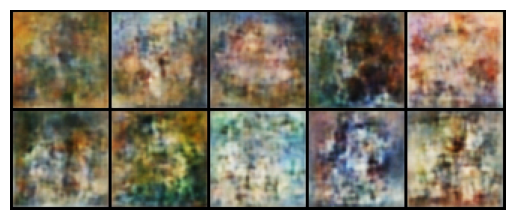

In [101]:
def generate_images(vae, num_images=10):
    vae.eval()
    
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_images, 256).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

# Generate and visualize 10 images
generate_images(vae, num_images=10)
